In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pandas as pd
import copy
from scipy.special import softmax

In [ ]:
def hairpin(grid_size: int):
    reward = [1,grid_size -2]
    blocks = []
    mid_a = int(grid_size // 5)
    mid_b = 2 * int(grid_size // 5)
    mid_c = 3 * int(grid_size // 5)
    mid_d = 4 * int(grid_size // 5)
    blocks_a = [[i, mid_a] for i in range(grid_size // 2 + 1 + grid_size // 4)]
    blocks_b = [[i, mid_b] for i in range(grid_size // 4 + 1, grid_size - 1)]
    blocks_c = [[i, mid_c] for i in range(grid_size // 2 + 1 + grid_size // 4)]
    blocks_d = [[i, mid_d] for i in range(grid_size // 4 + 1, grid_size - 1)]
    blocks = blocks_a + blocks_b + blocks_c + blocks_d
    valid_starts = []
    for i in range(grid_size):
        for j in range(grid_size):
            # check if position is not in blocks and is at least 10 tiles away from goal
            if [i, j] not in blocks and abs(i - (grid_size - 2)) + abs(j - 1) >= 10:
                valid_starts.append([i, j])
    # choose random start position from valid positions
    agent_start = random.choice(valid_starts)
    return blocks, agent_start, reward

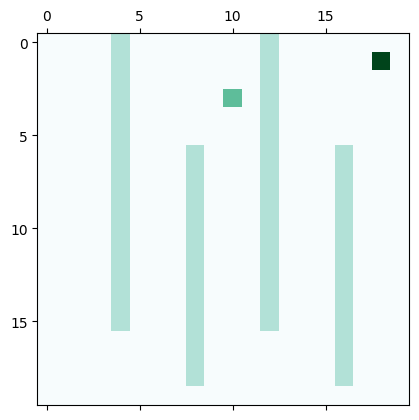

In [ ]:
# plot out the maze
my_maze = hairpin(20)
maze_blank = np.zeros((20,20))

for x in my_maze[0]:
  maze_blank[x[0],x[1]] = 6
maze_blank[my_maze[1][0],my_maze[1][1]] = 10
maze_blank[my_maze[2][0],my_maze[2][1]] = 19

plt.matshow(maze_blank,cmap='BuGn')

In [ ]:
class QLearningAgent:
    """
    Q-Learning Agent using softmax exploration
    """

    def __init__(
        self,
        env,
        state_size: int,
        lr: float,
        beta: float,
        action_size: int = 4,
        gamma: float = 0.99,
    ):
        self.reward = env[2]
        self.blocks = env[0]
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.beta = beta
        self.Q = np.zeros((state_size, action_size))
        self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))

    def choose_action(self, state_idx):
      probs = softmax(self.Q[state_idx, :]*self.beta)
      action = np.random.choice(range(len(probs)), p=probs)
      return action

    def update_Q(self, state_idx, action, reward, next_state_idx, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[next_state_idx, :])
        error = target - self.Q[state_idx, action]
        self.Q[state_idx, action] += self.lr * error

    def step(self, state, action, goal):        
        step_reward = 0
        next_pos = [0, 0]
        if action == 0: #moving up
            next_pos = [state[0] - 1, state[1]]
        elif action == 1: #moving down
            next_pos = [state[0] + 1, state[1]]
        elif action == 2: #moving left
            next_pos = [state[0], state[1] - 1]
        elif action == 3: #moving right
            next_pos = [state[0], state[1] + 1]
            
        if next_pos[0] <= 0 or next_pos[1] <= 0 or next_pos[0] >= int(self.state_size ** 0.5) or next_pos[1] >= int(self.state_size ** 0.5):
            next_state = state
            step_reward = 0
        elif next_pos in self.blocks:
            next_state = state
            step_reward = -0.1
        elif next_pos == self.reward:
            next_state = next_pos
            step_reward = goal
        else:
            next_state = next_pos
            step_reward = 0
        
        next_state_idx = np.ravel_multi_index(next_state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
        return next_state_idx, step_reward, next_state == self.reward

    def reset_env(self):
      _, state, _ = hairpin(grid_size)
      self.M = np.zeros((int(state_size ** 0.5), int(state_size ** 0.5)))
      return state

    def train(self, state, max_steps, goal): 
        total_reward = 0
        step = 0
        suc = 0
        state_idx_list = []
        action_list = []
        reward_list = []
        for step in range(max_steps):
            state_idx = np.ravel_multi_index(state, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state_idx_list.append(state_idx)
            action = self.choose_action(state_idx)
            action_list.append(action)
            next_state_idx, reward, done = self.step(state, action, goal)
            reward_list.append(reward)
            self.update_Q(state_idx, action, reward, next_state_idx, done)
            state = np.unravel_index(next_state_idx, (int(self.state_size ** 0.5), int(self.state_size ** 0.5)))
            state = [state[0],state[1]]
            self.M[state[0],state[1]] += 1
            total_reward += reward
            step += 1
            if done:
                suc = 1
                break
        return total_reward, step, self.M, suc, state_idx_list, action_list, reward_list
        
    def replay(self, suc, step, state_idx_list, action_list, reward_list, success):
        my_list = list(range(0, step))
        if suc == success:
          for x in my_list[::-1]:
            # current step
            state_idx = state_idx_list[x-1]
            action = action_list[x-1]
            reward = reward_list[x-1]
            # next step
            next_action = action_list[x]
            next_state_idx = state_idx_list[x]
            # update Q values
            target = reward + self.gamma * self.Q[next_state_idx, next_action]
            error = target - self.Q[state_idx, action]
            self.Q[state_idx, action] += self.lr * error
            if x == 1:
              break

In [ ]:
# Create empty lists
rewards = []
steps = [] 
visitations = []
Qs = [] 

# Set agent parameters
grid_size = 18
env = hairpin(grid_size)
state_size = grid_size ** 2
lr = 0.6
beta = 1 
goal = 10
success = 0
n_episodes = 250
max_steps = 1000

# Create Q-learning agent
agent = QLearningAgent(env, state_size, lr, beta)

# Let the agent learn! 
for episode in range(n_episodes):
  state = agent.reset_env()
  rews, step, M, suc, state_idx_list, action_list, reward_list = agent.train(state, max_steps, goal)
  agent.replay(suc, step, state_idx_list, action_list, reward_list, success)
  rewards.append(rews)
  steps.append(step)
  visitations.append(M)
  Qs.append(copy.deepcopy(agent.Q))

In [ ]:
# sns.heatmap(visitations[0], cmap='coolwarm')
# plt.show()
# sns.heatmap(visitations[150], cmap='coolwarm')
# plt.show()
# sns.heatmap(visitations[-1], cmap='coolwarm')
# plt.show()

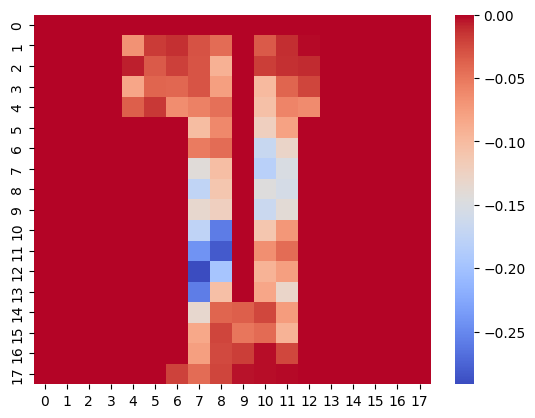

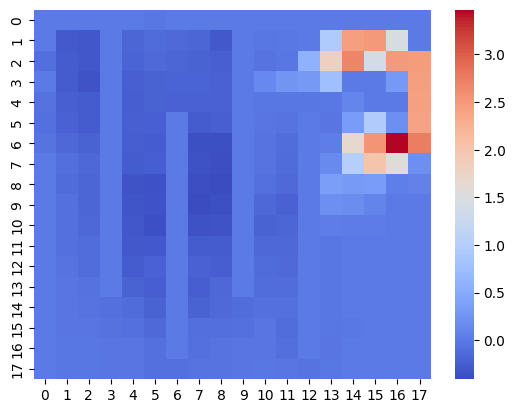

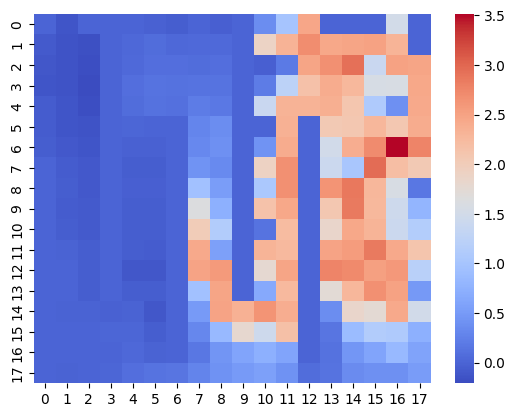

In [ ]:
# plot the learned value function after the 1st episode
avg_q_val_1 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[0][:][i])
  avg_q_val_1.append(n)

avg_q_val_1 = np.array(avg_q_val_1)
q_map_1 = avg_q_val_1.reshape((grid_size, grid_size))
sns.heatmap(q_map_1, cmap='coolwarm')
plt.show()

# plot the learned value function after the 50th episode
avg_q_val_2 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[49][:][i])
  avg_q_val_2.append(n)

avg_q_val_2 = np.array(avg_q_val_2)
q_map_2 = avg_q_val_2.reshape((grid_size, grid_size))
sns.heatmap(q_map_2, cmap='coolwarm')
plt.show()

# plot the learned value function after the 250th episode
avg_q_val_3 = []
for i in range(grid_size ** 2):
  n = np.mean(Qs[-1][:][i])
  avg_q_val_3.append(n)

avg_q_val_3 = np.array(avg_q_val_3)
q_map_3 = avg_q_val_3.reshape((grid_size, grid_size))
sns.heatmap(q_map_3, cmap='coolwarm')
plt.show()

In [ ]:
# # Number of steps (y-axis) needed by the RL agent in each consecutive episode (x-axis) to reach the goal location
# plt.plot(steps)
# plt.xlabel("Episode")
# plt.ylabel("Number of Steps to Goal")
# #plt.plot(np.array(rewards)/np.array(steps))

In [ ]:
# # Mean reward (y-axis) achieved by the RL agent in each consecutive episode (x-axis)
# plt.plot(rewards)
# plt.xlabel("Episode")
# plt.ylabel("Mean Reward")

Average steps (no replay): 531.74
Average steps (replay): 582.916
Mean reward (no replay): 0.8256000000000077
Mean reward (replay): -0.24199999999999164


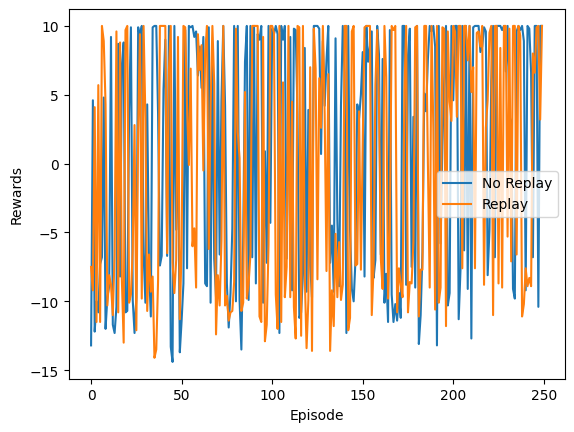

In [ ]:
# Set agent parameters
grid_size = 20
env = hairpin(grid_size)
state_size = grid_size ** 2
lr = 0.3
beta = 1 
goal = 10
success = 0
n_episodes = 250
max_steps = 1000

# Create Q-learning agent with replay
agent_replay = QLearningAgent(env, state_size, lr, beta)
# Create Q-learning agent with no replay
agent_no_replay = QLearningAgent(env, state_size, lr, beta)

# Create empty lists
steps_replay = []
steps_no_replay = []
rewards_replay = []
rewards_no_replay = []

# Train our agent with and without replay
for episode in range(n_episodes):
    state_re = agent_replay.reset_env()
    state = agent_no_replay.reset_env()
    
    # Train with replay
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_replay.train(state_re, max_steps,goal)
    agent_replay.replay(suc, step, state_idx_list, action_list, reward_list, success)
    steps_replay.append(step)
    rewards_replay.append(rews)
    
    # Train without replay
    rews, step, M, suc, state_idx_list, action_list, reward_list = agent_no_replay.train(state, max_steps,goal)
    steps_no_replay.append(step)
    rewards_no_replay.append(rews)

# Compare the average number of steps
avg_steps_replay = sum(steps_replay) / len(steps_replay)
avg_steps_no_replay = sum(steps_no_replay) / len(steps_no_replay)

# Compare the mean rewards
avg_reward_replay = sum(rewards_replay) / len(steps_replay)
avg_reward_no_replay = sum(rewards_no_replay) / len(steps_no_replay)

print("Average steps (no replay):", avg_steps_no_replay)
print("Average steps (replay):", avg_steps_replay)
print("Mean reward (no replay):", avg_reward_no_replay)
print("Mean reward (replay):", avg_reward_replay)

# Visualize the results (steps)
# plt.plot(steps_no_replay, label="No Replay")
# plt.plot(steps_replay, label="Replay")
# plt.xlabel("Episode")
# plt.ylabel("Steps")
# plt.legend()
# plt.show()

# Visualize the results (rewards)
plt.plot(rewards_no_replay, label="No Replay")
plt.plot(rewards_replay, label="Replay")
plt.xlabel("Episode")
plt.ylabel("Rewards")
plt.legend()
plt.show()

Average rewards per step (no replay) for success=1, max_steps=500: 0.001200375612349957
Average rewards per step (replay) for success=1, max_steps=500: 0.006128377571729877


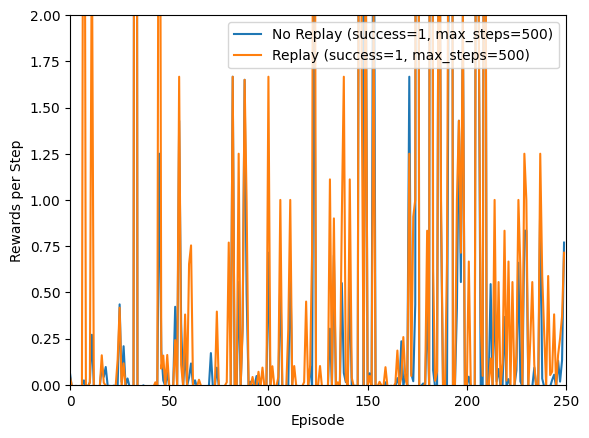

Average rewards per step (no replay) for success=0, max_steps=500: 0.008572780933288783
Average rewards per step (replay) for success=0, max_steps=500: 0.027063335794568863


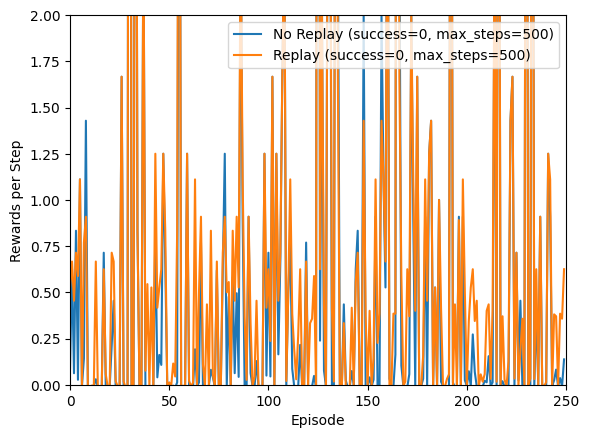

Average rewards per step (no replay) for success=1, max_steps=1000: 0.0274840007917134
Average rewards per step (replay) for success=1, max_steps=1000: 0.07331331859720898


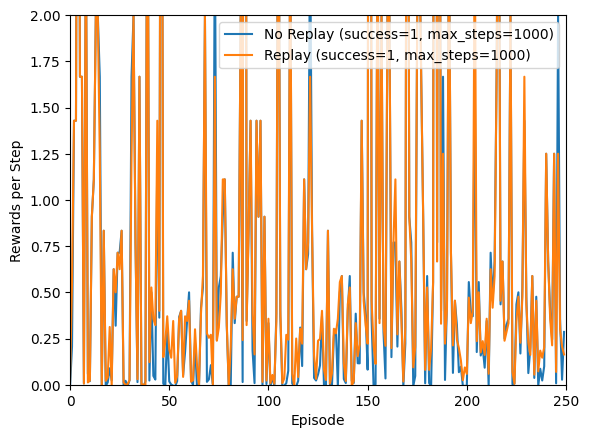

Average rewards per step (no replay) for success=0, max_steps=1000: 0.07889159986057863
Average rewards per step (replay) for success=0, max_steps=1000: 0.19902343750000007


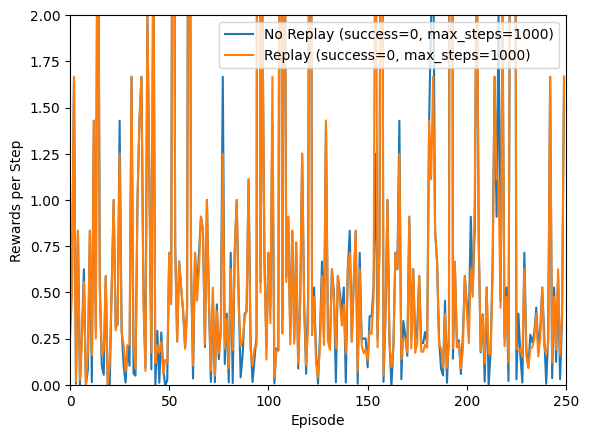

In [ ]:
# Set agent parameters
grid_size = 20
env = hairpin(grid_size)
state_size = grid_size ** 2
lr = 0.3
beta = 1 
goal = 10
n_episodes = 250

# Create Q-learning agent with replay
agent_replay = QLearningAgent(env, state_size, lr, beta)
# Create Q-learning agent with no replay
agent_no_replay = QLearningAgent(env, state_size, lr, beta)

# Define test conditions
test_conditions = [
    {"success": 1, "max_steps": 500},
    {"success": 0, "max_steps": 500},
    {"success": 1, "max_steps": 1000},
    {"success": 0, "max_steps": 1000}
]

# Train and compare the agent with and without replay for each test condition
for test_condition in test_conditions:
    success = test_condition["success"]
    max_steps = test_condition["max_steps"]
    steps_replay = []
    steps_no_replay = []
    rewards_replay = []
    rewards_no_replay = []
    rew_steps_replay_list = []
    rew_steps_no_replay_list = []

    for episode in range(n_episodes):
        state_re = agent_replay.reset_env()
        state = agent_no_replay.reset_env()
        
        # Train with replay
        rews, step, M, suc, state_idx_list, action_list, reward_list = agent_replay.train(state, max_steps, goal)
        agent_replay.replay(suc, step, state_idx_list, action_list, reward_list, success)
        steps_replay.append(step)
        rewards_replay.append(rews)
        rew_steps_replay = rews / step
        rew_steps_replay_list.append(rew_steps_replay)

        # Train without replay
        rews, step, M, suc, state_idx_list, action_list, reward_list = agent_no_replay.train(state, max_steps, goal)
        steps_no_replay.append(step)
        rewards_no_replay.append(rews)
        rew_steps_no_replay = rews / step
        rew_steps_no_replay_list.append(rew_steps_no_replay)

    # Compute average rewards per step
    avg_rew_steps_replay = sum(rewards_replay) / sum(steps_replay)
    avg_rew_steps_no_replay = sum(rewards_no_replay) / sum(steps_no_replay)

    print(f"Average rewards per step (no replay) for success={success}, max_steps={max_steps}:", avg_rew_steps_no_replay)
    print(f"Average rewards per step (replay) for success={success}, max_steps={max_steps}:", avg_rew_steps_replay)

    # Visualize the results
    plt.plot(rew_steps_no_replay_list, label=f"No Replay (success={success}, max_steps={max_steps})")
    plt.plot(rew_steps_replay_list, label=f"Replay (success={success}, max_steps={max_steps})")
    plt.xlim([0, 250])
    plt.ylim([0, 2])
    plt.xlabel("Episode")
    plt.ylabel("Rewards per Step")
    plt.legend()
    plt.show()
